In [1]:
import numpy as np
from nn import *

In [2]:
from ucimlrepo import fetch_ucirepo
import pickle
import os

# Check if data exists, download if required
# save to disk after download to speed up on between runs

if os.path.exists("./data.pkl"):
    with open("./data.pkl", 'rb') as fp:
        rt_iot2022 = pickle.load(fp)
else:
    rt_iot2022 = fetch_ucirepo(id=942)
    with open("./data.pkl", 'wb') as fp:
        pickle.dump(rt_iot2022, fp)

In [3]:
# Remove axes that don't contribute to data, and get labels
features = rt_iot2022.data.features
targets = rt_iot2022.data.targets

unique = features.nunique(axis=0)
for i in range(len(unique)):
    if unique[i] <= 1:
        print("Removing", features.axes[1][i])
        del features[features.axes[1][i]]
# bwd_URG_flag count is always the same, usually removed

# Get labels for data (attack or normal behavior)
normal_patterns = ["MQTT_Publish", "Thing_Speak", "Wipro_bulb", "Amazon-Alexa"]
y_bool = [int(x in normal_patterns) for x in targets.values]

/tmp/ipykernel_1089446/875652746.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique[i] <= 1:


Removing bwd_URG_flag_count


In [4]:
# convert string to numerical
unique_service = list(features["service"].unique())
unique_proto = list(features["proto"].unique())
for i in range(len(features["service"])):
    features.loc[i, "service"] = unique_service.index(features["service"][i])
    features.loc[i, "proto"] = unique_proto.index(features["proto"][i])

In [5]:
# use only continous vars
# continuous_vars = rt_iot2022.variables[rt_iot2022.variables['type'] == "Continuous"]['name'].tolist()
# features = features[continuous_vars]

In [6]:
# fit all data from -1 to 1
def normalize_axis(axis):
    return (axis - axis.min()) / (axis.max() - axis.min())

X = features.values
X = X.T
for idx in range(len(X)):
    X[idx] = normalize_axis(X[idx]) 
X = X.T
X = X.astype('float64')

X.shape

(123117, 82)

In [7]:
# Split data into train/test sets
y = np.array(y_bool)
np.random.seed(2)

test_split = .2
test_samples = int(len(X) * test_split)
perm  = np.random.permutation(len(X))
X = X[perm]
y = y[perm]

x_train = X[0:test_samples]
y_train = y[0:test_samples]
x_test  = X[test_samples:]
y_test  = y[test_samples:]

In [8]:
x_train = x_train.reshape((x_train.shape[0], 1, -1))
x_test = x_test.reshape((x_test.shape[0],1,-1))

In [16]:
model = Network()
model.add(FullyConnected(x_train.shape[2], 100))
model.add(Activation(tanh, tanh_prime))
model.add(FullyConnected(100, 50))
model.add(Activation(tanh, tanh_prime))
model.add(FullyConnected(50, 1))
model.add(Activation(tanh, tanh_prime))

model.use_loss(mse, mse_prime)

In [17]:
model.fit(x_train, y_train, 100, .01)
# model.fit(x_train, y_train, 40, .01)

epoch 0/100      error=0.03353404372686378
epoch 1/100      error=0.023354348334273606
epoch 2/100      error=0.020846237853998376
epoch 3/100      error=0.019286022411351696
epoch 4/100      error=0.01808842707078467
epoch 5/100      error=0.017094447299062978
epoch 6/100      error=0.0162392844637169
epoch 7/100      error=0.015465139316637061
epoch 8/100      error=0.014742228997404093
epoch 9/100      error=0.01405434932299565
epoch 10/100      error=0.013395936307861686
epoch 11/100      error=0.01276682448710886
epoch 12/100      error=0.012172524290860852
epoch 13/100      error=0.011621607311810576
epoch 14/100      error=0.011119624026260506
epoch 15/100      error=0.010666795776140105
epoch 16/100      error=0.010258456735547318
epoch 17/100      error=0.009887959067763552
epoch 18/100      error=0.00955284917768064
epoch 19/100      error=0.009252596322959007
epoch 20/100      error=0.008983947035571765
epoch 21/100      error=0.008742204099004539
epoch 22/100      error=0.0

In [21]:
import time

start = time.time()

predicted_class = np.array(model.predict(x_test))
predicted = predicted_class > .5
predicted = np.ravel(predicted)

print(f"Took {time.time() - start}")

true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
for i in range(len(predicted)):
    if predicted[i] == 1:
        if predicted[i] == y_test[i]:
            true_positive += 1
        else:
            false_positive += 1
    elif predicted[i] == 0:
        if predicted[i] == y_test[i]:
            true_negative += 1
        else:
            false_negative += 1

pos_acc = true_positive / (true_positive + false_positive)
neg_acc = true_negative / (true_negative + false_negative)

print(f"pos_acc: {pos_acc}, neg_acc: {neg_acc}")

print("NN raw accuracy is:", (true_positive + true_negative)/len(predicted))
print("Balanced Acc is: ", (pos_acc+neg_acc)/2)

# TODO: why is this so high, leaking train data? or including id/label?

Took 0.8044967651367188
pos_acc: 0.9709843533372945, neg_acc: 0.9974998868727092
NN raw accuracy is: 0.9947814080045485
Balanced Acc is:  0.9842421201050018


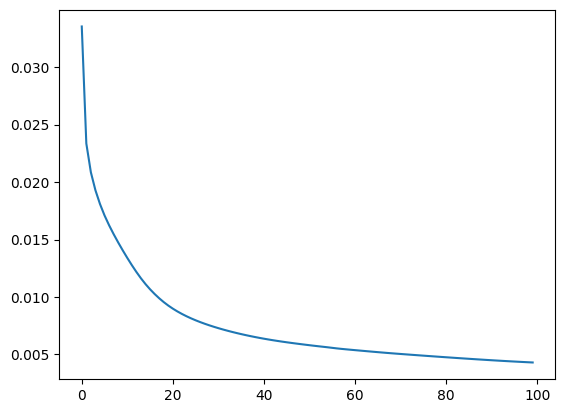

In [19]:
import matplotlib.pyplot as plt

plt.plot(model.losses)